<a href="https://colab.research.google.com/github/puruyadav-tech/fraud-detector-app/blob/main/fraud_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

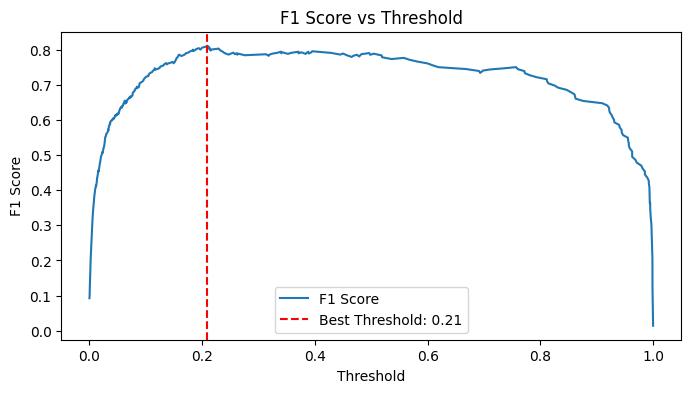


Manual Thresholds F1 Check:
Threshold: 0.10 → F1 Score: 0.7230
Threshold: 0.20 → F1 Score: 0.8082
Threshold: 0.25 → F1 Score: 0.7885
Threshold: 0.30 → F1 Score: 0.7868
Threshold: 0.35 → F1 Score: 0.7879
Threshold: 0.40 → F1 Score: 0.7905
Threshold: 0.45 → F1 Score: 0.7840
Threshold: 0.50 → F1 Score: 0.7884

Classification Report on Validation Data:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2722
           1       0.78      0.85      0.81       139

    accuracy                           0.98      2861
   macro avg       0.88      0.92      0.90      2861
weighted avg       0.98      0.98      0.98      2861

Confusion Matrix:
 [[2688   34]
 [  21  118]]
Final F1 Score: 0.8109965635738832


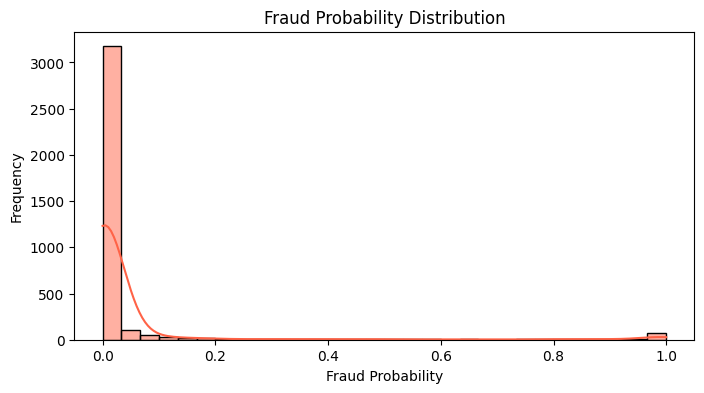

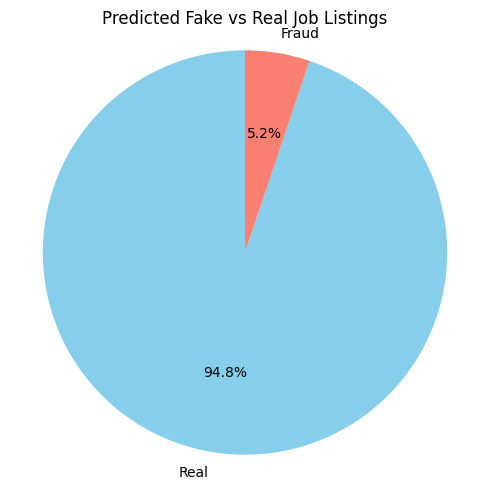

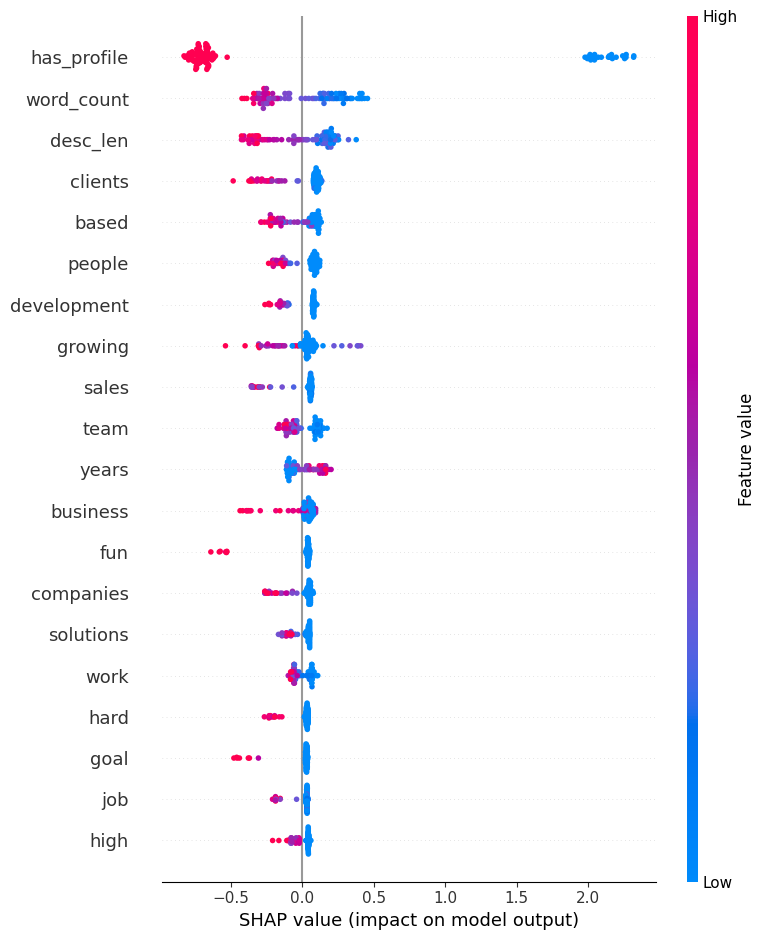

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve

from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings("ignore")

# 1. Load Data
train_df = pd.read_csv("training data.csv", on_bad_lines='skip')
test_df = pd.read_csv("Test data.csv", on_bad_lines='skip')

# 2. Feature Engineering
def prepare(df):
    df = df.copy()

    for col in ['title', 'description', 'requirements', 'company_profile']:
        if col not in df.columns:
            df[col] = ''
        df[col] = df[col].fillna('')

    if 'email' not in df.columns:
        df['email'] = ''
    else:
        df['email'] = df['email'].fillna('')

    df['text'] = df['title'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['company_profile']
    df['desc_len'] = df['description'].apply(len)
    df['word_count'] = df['description'].apply(lambda x: len(x.split()))
    df['num_digits_in_title'] = df['title'].apply(lambda x: sum(c.isdigit() for c in x))
    df['has_profile'] = np.where(df['company_profile'] == '', 0, 1)

    suspicious_words = ['money', 'wire', 'bitcoin', 'transfer', 'click']
    df['suspicious_terms'] = df['description'].apply(
        lambda x: int(any(term in x.lower() for term in suspicious_words))
    )

    df['email_domain'] = df['email'].apply(lambda x: x.split('@')[-1] if '@' in x else '')
    df['free_email'] = df['email_domain'].isin(['gmail.com', 'yahoo.com', 'hotmail.com']).astype(int)

    return df

train_df = prepare(train_df)
test_df = prepare(test_df)

# 3. Split Features and Labels
X = train_df[['text', 'desc_len', 'word_count', 'num_digits_in_title', 'has_profile', 'suspicious_terms', 'free_email']]
y = train_df['fraudulent']
X_test = test_df[['text', 'desc_len', 'word_count', 'num_digits_in_title', 'has_profile', 'suspicious_terms', 'free_email']]

# 4. TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf.fit_transform(X['text'])
X_test_tfidf = tfidf.transform(X_test['text'])

# 5. Combine TF-IDF with Numeric Features
from scipy.sparse import hstack

X_combined = hstack([
    X_tfidf,
    X[['desc_len', 'word_count', 'num_digits_in_title', 'has_profile', 'suspicious_terms', 'free_email']].values
])

X_test_combined = hstack([
    X_test_tfidf,
    X_test[['desc_len', 'word_count', 'num_digits_in_title', 'has_profile', 'suspicious_terms', 'free_email']].values
])

# 6. Train-Test Split and SMOTE for Imbalance Handling
X_train_part, X_val, y_train_part, y_val = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_part, y_train_part)

# 7. Train XGBoost Model
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_res, y_res)

# 8. Threshold Tuning on Validation Set
val_probs = model.predict_proba(X_val)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_val, val_probs)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_threshold = thresholds[np.argmax(f1s)]

# 9. Plot F1 vs Threshold
plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1s[:-1], label='F1 Score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.legend()
plt.show()

# 10. F1 Score at Various Thresholds
print("\nManual Thresholds F1 Check:")
for t in [0.1,0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    preds = (val_probs > t).astype(int)
    f1 = f1_score(y_val, preds)
    print(f"Threshold: {t:.2f} → F1 Score: {f1:.4f}")

# 11. Final Validation Metrics
val_preds = (val_probs >= best_threshold).astype(int)
print("\nClassification Report on Validation Data:")
print(classification_report(y_val, val_preds))
print("Confusion Matrix:\n", confusion_matrix(y_val, val_preds))
print("Final F1 Score:", f1_score(y_val, val_preds))

# 12. Prediction on Test Set
test_probs = model.predict_proba(X_test_combined)[:, 1]
test_df['fraud_probability'] = test_probs
test_df['fraud_predicted'] = (test_probs >= best_threshold).astype(int)

# 13. Visualize Prediction Distribution
plt.figure(figsize=(8, 4))
sns.histplot(test_df['fraud_probability'], bins=30, kde=True, color="tomato")
plt.title("Fraud Probability Distribution")
plt.xlabel("Fraud Probability")
plt.ylabel("Frequency")
plt.show()

# 14. Pie Chart of Predictions
fraud_counts = test_df['fraud_predicted'].value_counts()
labels = ['Real', 'Fraud']
colors = ['skyblue', 'salmon']
plt.figure(figsize=(5, 5))
plt.pie(fraud_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Predicted Fake vs Real Job Listings")
plt.axis('equal')
plt.tight_layout()
plt.show()

# 15. SHAP Explanations
X_res_dense = X_res[:100].toarray()
explainer = shap.Explainer(model, X_res_dense)
shap_values = explainer(X_res_dense)

feature_names = tfidf.get_feature_names_out().tolist() + [
    'desc_len', 'word_count', 'num_digits_in_title', 'has_profile', 'suspicious_terms', 'free_email'
]

shap.summary_plot(shap_values, X_res_dense, feature_names=feature_names)

# 16. Identify High-Risk Job Listings
high_risk_df = test_df[test_df['fraud_probability'] >= 0.8]

if not high_risk_df.empty:
    alert_message = "High-Risk Job Listings Detected:\n\n"
    for idx, row in high_risk_df.iterrows():
        alert_message += f"- Title: {row['title']}\n  Location: {row.get('location', 'N/A')}\n  Probability: {row['fraud_probability']:.2f}\n\n"
